In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [ ]:
# 데이터 로드
data = fetch_openml(name='adult', version=1, as_frame=True)
df = data.frame

display(df.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [ ]:
# 데이터 전처리 함수
def preprocess_dataframe(df):
    df_processed = df.copy()

    for column in df_processed.columns:
        # 카테고리 처리
        if df_processed[column].dtype == 'category' or df_processed[column].dtype == 'object':
            # 'Unknown' 카테고리 추가
            if pd.api.types.is_categorical_dtype(df_processed[column]):
                df_processed[column] = df_processed[column].cat.add_categories(['Unknown'])
            # 결측값 대체
            df_processed[column] = df_processed[column].fillna('Unknown')

            # 레이블 인코딩
            le = LabelEncoder()
            df_processed[column] = le.fit_transform(df_processed[column].astype(str))

        # 수치형 처리
        elif df_processed[column].dtype in ['int64', 'float64']:
            # 결측값 중앙값으로 대체
            df_processed[column] = df_processed[column].fillna(df_processed[column].median())

    return df_processed

# 데이터 전처리
df_processed = preprocess_dataframe(df)

display(df_processed.head())

<ipython-input-48-6f6006bbebc5>:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-48-6f6006bbebc5>:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-48-6f6006bbebc5>:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-48-6f6006bbebc5>:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-48-6f6006

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,6,77516,9,13,4,0,1,4,1,1,0,2,38,0
1,3,5,83311,9,13,2,3,0,4,1,0,0,0,38,0
2,2,3,215646,11,9,0,5,1,4,1,0,0,2,38,0
3,3,3,234721,1,7,2,5,0,2,1,0,0,2,38,0
4,1,3,338409,9,13,2,9,5,2,0,0,0,2,4,0


In [ ]:
# 특성과 타겟 분리
X_data = df_processed.drop('class', axis=1)
y_data = df_processed['class']

# 이진 클래스 레이블 변환
y_data = (y_data == 1).astype(int)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [ ]:
# 데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

display(X_train[:5])

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

array([[-0.59312387, -0.22874825, -1.31597473,  0.18431941, -0.42010768,
        -0.41107463,  1.51035573, -0.90178847,  0.39155354,  0.70444817,
        -0.27070992, -0.20625552,  0.0574821 ,  0.25391754],
       [ 0.17809506,  1.86918161, -0.43145742,  0.44190774,  1.52903114,
        -0.41107463,  0.58669406, -0.90178847,  0.39155354,  0.70444817,
        -0.27070992, -0.20625552,  0.0574821 ,  0.25391754],
       [-0.59312387, -1.62736817,  0.58789495, -2.13397559, -0.80993545,
        -0.41107463, -0.56788302, -0.90178847,  0.39155354,  0.70444817,
        -0.27070992, -0.20625552,  0.0574821 ,  0.25391754],
       [ 1.72053292, -0.22874825, -1.13857608,  0.18431941, -0.42010768,
        -1.73899983, -1.02971386,  1.59214796,  0.39155354,  0.70444817,
        -0.27070992, -0.20625552, -2.17179656,  0.25391754],
       [ 1.72053292,  1.16987166, -1.52521101,  0.18431941, -0.42010768,
         2.24477576,  1.0485249 , -0.27830436,  0.39155354,  0.70444817,
        -0.27070992, -0.20

In [ ]:
print(X_train[:5])
print(y_train[:5])

[[-0.59312387 -0.22874825 -1.31597473  0.18431941 -0.42010768 -0.41107463
   1.51035573 -0.90178847  0.39155354  0.70444817 -0.27070992 -0.20625552
   0.0574821   0.25391754]
 [ 0.17809506  1.86918161 -0.43145742  0.44190774  1.52903114 -0.41107463
   0.58669406 -0.90178847  0.39155354  0.70444817 -0.27070992 -0.20625552
   0.0574821   0.25391754]
 [-0.59312387 -1.62736817  0.58789495 -2.13397559 -0.80993545 -0.41107463
  -0.56788302 -0.90178847  0.39155354  0.70444817 -0.27070992 -0.20625552
   0.0574821   0.25391754]
 [ 1.72053292 -0.22874825 -1.13857608  0.18431941 -0.42010768 -1.73899983
  -1.02971386  1.59214796  0.39155354  0.70444817 -0.27070992 -0.20625552
  -2.17179656  0.25391754]
 [ 1.72053292  1.16987166 -1.52521101  0.18431941 -0.42010768  2.24477576
   1.0485249  -0.27830436  0.39155354  0.70444817 -0.27070992 -0.20625552
   2.28676077  0.25391754]]
37193    0
31093    1
33814    0
14500    0
23399    0
Name: class, dtype: int64


In [ ]:
# 컬럼 간 상호작용 클래스
class ColumnWiseInteraction(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.interaction_weights = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        interactions = torch.matmul(x, self.interaction_weights)
        return torch.cat([x, interactions], dim=1)


In [ ]:
interaction_layer = ColumnWiseInteraction(input_dim=14)
output = interaction_layer(X_train)

print("입력 크기:", X_train.shape)       # (5, 14)
print("출력 크기:", output.shape)           # (5, 28)

print(output[:5])

입력 크기: torch.Size([39073, 14])
출력 크기: torch.Size([39073, 28])
tensor([[-0.5931, -0.2287, -1.3160,  0.1843, -0.4201, -0.4111,  1.5104, -0.9018,
          0.3916,  0.7044, -0.2707, -0.2063,  0.0575,  0.2539, -4.6829, -3.7943,
          2.9512, -2.2306, -4.1814,  0.2992,  3.6329, -0.9117, -1.1673,  2.7219,
         -1.7072, -1.7648,  4.6256,  0.8690],
        [ 0.1781,  1.8692, -0.4315,  0.4419,  1.5290, -0.4111,  0.5867, -0.9018,
          0.3916,  0.7044, -0.2707, -0.2063,  0.0575,  0.2539,  2.0853,  0.2078,
         -4.1610, -3.6156, -0.6389,  0.7507, -1.0324, -0.2614, -0.6570,  0.6471,
         -2.1237, -2.9956,  1.6085, -4.3781],
        [-0.5931, -1.6274,  0.5879, -2.1340, -0.8099, -0.4111, -0.5679, -0.9018,
          0.3916,  0.7044, -0.2707, -0.2063,  0.0575,  0.2539, -5.2247, -2.9147,
          2.8095,  0.0687, -2.6100,  3.7295,  0.0902,  3.2760,  0.6048,  6.6930,
         -2.9757, -1.2258, -2.3509,  2.2704],
        [ 1.7205, -0.2287, -1.1386,  0.1843, -0.4201, -1.7390, -1.0297,

In [ ]:
# 가중치행렬
print(interaction_layer.interaction_weights.shape)
print(interaction_layer.interaction_weights)

torch.Size([14, 14])
Parameter containing:
tensor([[ 9.1314e-02,  4.7033e-01, -2.1805e+00, -4.6119e-01, -2.0294e+00,
         -1.7931e-01, -1.9269e-01, -8.1544e-02, -1.4613e-01, -1.1451e+00,
         -5.1923e-01, -1.0752e+00,  6.4827e-01,  3.1683e-01],
        [ 1.3366e+00,  2.1672e-01, -1.3603e+00,  2.2084e-02,  9.2967e-01,
          1.6150e-01, -7.6521e-01, -6.7436e-01,  1.9136e-01, -8.0391e-01,
          9.6743e-01, -2.2129e-01,  3.1991e-01, -5.3551e-01],
        [ 4.3306e-01,  9.2413e-01, -1.8669e+00,  1.6148e+00,  1.1531e+00,
         -5.6172e-01, -1.4152e+00,  9.5731e-01,  9.8073e-02, -1.2358e-01,
          5.4920e-01, -4.3348e-01, -8.7723e-01,  5.6943e-01],
        [ 4.3078e-01,  3.6173e-01,  4.0866e-01, -8.7267e-01,  5.4326e-01,
         -1.6070e+00,  3.4064e-01, -4.7587e-02, -3.0370e-01, -1.3475e+00,
          6.6355e-01,  6.1441e-01,  8.2025e-01, -6.1468e-01],
        [ 1.2873e+00,  1.0167e+00, -1.0003e+00, -4.9435e-01,  5.3571e-01,
          3.3794e-01, -5.8687e-01,  3.3476e

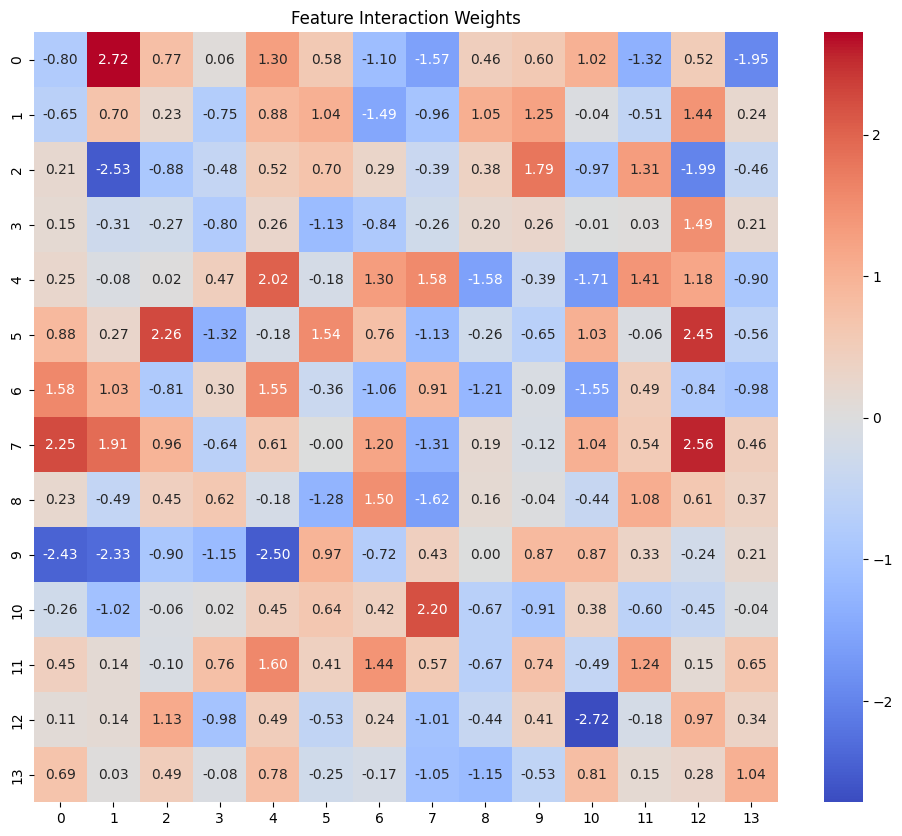

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 가중치 행렬을 히트맵으로 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(interaction_layer.interaction_weights.detach().numpy(),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Feature Interaction Weights')
plt.show()

In [ ]:
def analyze_interactions(weights):
    # 절대값 기준으로 상위 N개 상호작용 찾기
    abs_weights = torch.abs(weights)
    top_interactions = []

    for i in range(len(weights)):
        for j in range(len(weights)):
            if i != j:
                top_interactions.append((i, j, abs_weights[i, j].item()))

    # 상호작용 강도 기준 내림차순 정렬
    top_interactions.sort(key=lambda x: x[2], reverse=True)

    return top_interactions

# 상위 10개 상호작용 출력
top_10 = analyze_interactions(interaction_layer.interaction_weights)
for idx, (col1, col2, strength) in enumerate(top_10[:10], 1):
    print(f"{idx}. 컬럼 {col1}과 컬럼 {col2} 간 상호작용 강도: {strength:.4f}")

1. 컬럼 7과 컬럼 3 간 상호작용 강도: 2.6506
2. 컬럼 11과 컬럼 7 간 상호작용 강도: 2.4516
3. 컬럼 12과 컬럼 10 간 상호작용 강도: 2.3312
4. 컬럼 7과 컬럼 4 간 상호작용 강도: 2.3148
5. 컬럼 7과 컬럼 10 간 상호작용 강도: 2.2520
6. 컬럼 0과 컬럼 2 간 상호작용 강도: 2.1805
7. 컬럼 11과 컬럼 4 간 상호작용 강도: 2.1460
8. 컬럼 8과 컬럼 13 간 상호작용 강도: 2.0935
9. 컬럼 12과 컬럼 7 간 상호작용 강도: 2.0421
10. 컬럼 0과 컬럼 4 간 상호작용 강도: 2.0294


상호작용 가중치 통계:
평균: 0.8154
표준편차: 0.6239
최대값: 2.8355
최소값: 0.0010

상위 5% 상호작용 임계값: 1.8997693359851837


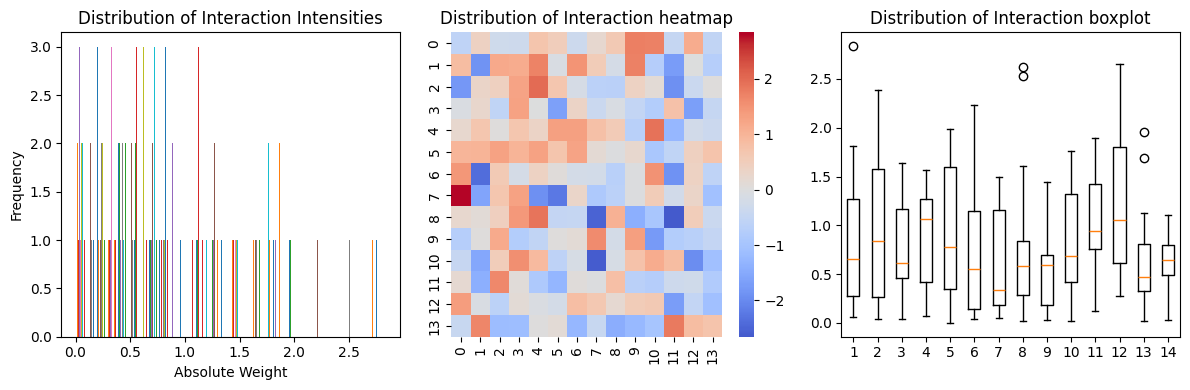

In [ ]:
def advanced_interaction_analysis(weights):
    # 1. 상호작용 행렬 기본 통계
    abs_weights = torch.abs(weights)
    print("상호작용 가중치 통계:")
    print(f"평균: {abs_weights.mean().item():.4f}")
    print(f"표준편차: {abs_weights.std().item():.4f}")
    print(f"최대값: {abs_weights.max().item():.4f}")
    print(f"최소값: {abs_weights.min().item():.4f}")

    # 2. 상위/하위 상호작용 분석
    top_5_percentile = np.percentile(abs_weights.detach().numpy(), 95)

    print("\n상위 5% 상호작용 임계값:", top_5_percentile)

    # 3. 상호작용 분포 시각화
    plt.figure(figsize=(12, 4))

    # 히스토그램
    plt.subplot(131)
    plt.hist(abs_weights.detach().numpy(), bins=30)  # .detach() 추가
    plt.title('Distribution of Interaction Intensities')
    plt.xlabel('Absolute Weight')
    plt.ylabel('Frequency')

    # 히트맵
    plt.subplot(132)
    sns.heatmap(weights.detach().numpy(),
                cmap='coolwarm',
                center=0,
                annot=False)
    plt.title('Distribution of Interaction heatmap')

    # 박스플롯
    plt.subplot(133)
    plt.boxplot(abs_weights.detach().numpy())  # .detach() 추가
    plt.title('Distribution of Interaction boxplot')

    plt.tight_layout()
    plt.show()

# 모듈 생성 및 분석
interaction_layer = ColumnWiseInteraction(input_dim=14)
advanced_interaction_analysis(interaction_layer.interaction_weights)

원본 입력 크기: torch.Size([5, 14])
출력 크기: torch.Size([5, 28])
중요도 가중치 크기: torch.Size([5, 14])


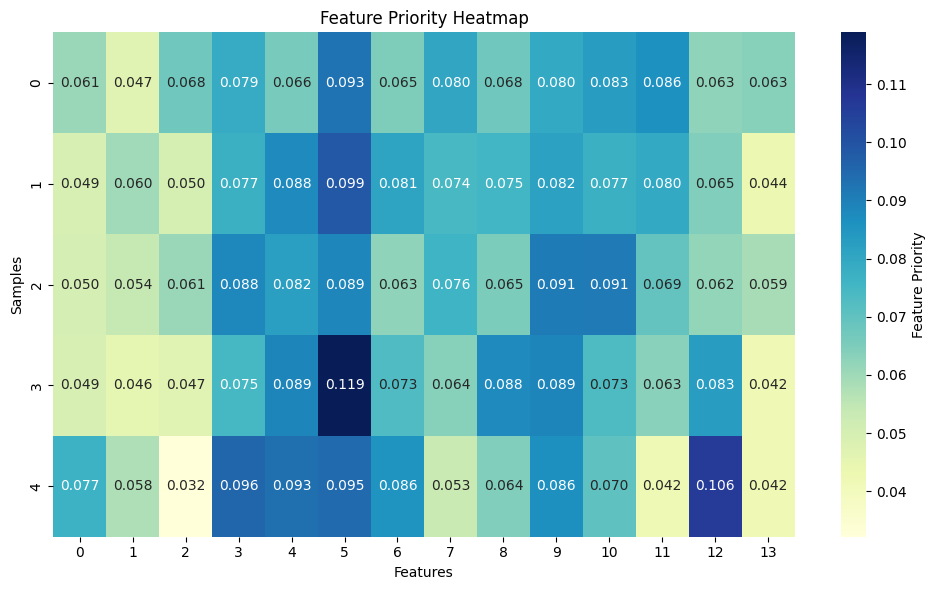

In [ ]:
class ColumnWiseInteractionWithPriority(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # 상호작용 가중치 행렬
        self.interaction_weights = nn.Parameter(torch.randn(input_dim, input_dim))

        # 중요도 우선순위를 위한 추가 레이어
        self.priority_layer = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.Softmax(dim=1)  # 각 특성의 중요도를 확률 분포로 변환
        )

    def forward(self, x):
        # 원본 상호작용
        interactions = torch.matmul(x, self.interaction_weights)

        # 중요도 우선순위 계산
        priority_weights = self.priority_layer(x)

        # 상호작용에 중요도 가중
        weighted_interactions = interactions * priority_weights

        # 원본 입력과 가중된 상호작용 결합
        return torch.cat([x, weighted_interactions], dim=1), priority_weights

# 사용 예시
input_dim = 14
interaction_layer = ColumnWiseInteractionWithPriority(input_dim)

# 예시 입력
x = torch.randn(5, input_dim)

# 순전파
output, priority = interaction_layer(x)

print("원본 입력 크기:", x.shape)
print("출력 크기:", output.shape)
print("중요도 가중치 크기:", priority.shape)

# 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(priority.detach().numpy(),
            cmap='YlGnBu',
            annot=True,
            fmt='.3f',
            cbar_kws={'label': 'Feature Priority'})
plt.title('Feature Priority Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.tight_layout()
plt.show()

In [ ]:
# Transformer 기반 분류 모델
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_classes):
        super().__init__()
        self.column_interaction = ColumnWiseInteraction(input_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, input_dim * 2))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim * 2,
            nhead=num_heads,
            dim_feedforward=hidden_dim
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.classifier = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.column_interaction(x)
        x = x + self.positional_encoding.expand_as(x)
        x = x.unsqueeze(0)
        x = self.transformer_encoder(x)
        x = x.squeeze(0)
        return self.classifier(x)

In [ ]:
# 모델 학습 함수
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
# 모델 평가 함수
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return 100 * correct / total

In [ ]:
# AUROC 계산 및 시각화 함수
def calculate_and_plot_auroc(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = torch.softmax(model(batch_x), dim=1)
            probs = outputs[:, 1].cpu().numpy()
            labels = batch_y.cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels)

    auroc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return auroc

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
 10%|█         | 1/10 [00:08<01:16,  8.47s/it]

Epoch [1/10], Loss: 0.3552, Test Accuracy: 84.24%


 20%|██        | 2/10 [00:13<00:51,  6.46s/it]

Epoch [2/10], Loss: 0.3328, Test Accuracy: 84.62%


 30%|███       | 3/10 [00:19<00:44,  6.34s/it]

Epoch [3/10], Loss: 0.3288, Test Accuracy: 84.56%


 40%|████      | 4/10 [00:24<00:35,  5.91s/it]

Epoch [4/10], Loss: 0.3261, Test Accuracy: 84.88%


 50%|█████     | 5/10 [00:30<00:29,  5.82s/it]

Epoch [5/10], Loss: 0.3244, Test Accuracy: 84.50%


 60%|██████    | 6/10 [00:36<00:23,  5.80s/it]

Epoch [6/10], Loss: 0.3228, Test Accuracy: 84.75%


 70%|███████   | 7/10 [00:41<00:16,  5.59s/it]

Epoch [7/10], Loss: 0.3218, Test Accuracy: 84.69%


 80%|████████  | 8/10 [00:47<00:11,  5.79s/it]

Epoch [8/10], Loss: 0.3220, Test Accuracy: 84.98%


 90%|█████████ | 9/10 [00:53<00:05,  5.63s/it]

Epoch [9/10], Loss: 0.3204, Test Accuracy: 84.58%


100%|██████████| 10/10 [00:59<00:00,  5.94s/it]

Epoch [10/10], Loss: 0.3193, Test Accuracy: 84.93%


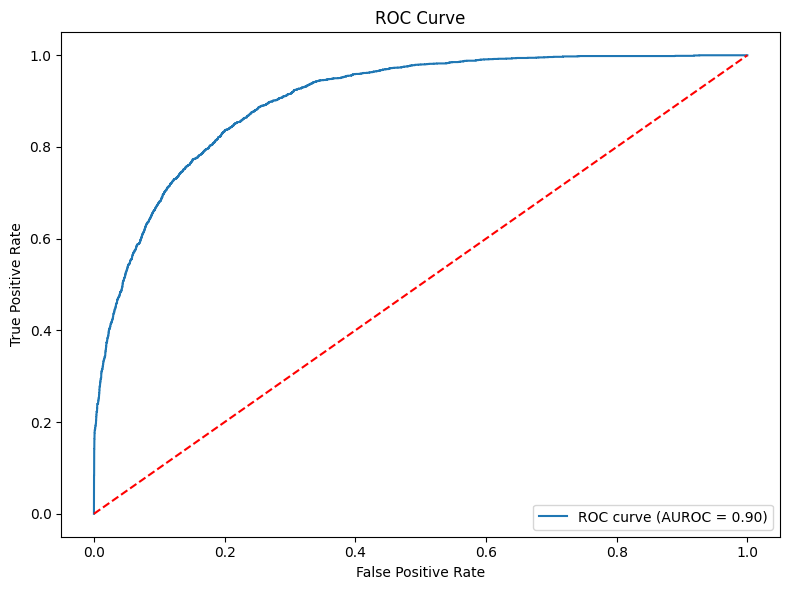

AUROC: 0.9028


In [55]:
# 메인 함수
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_dim = X_train.shape[1]
    hidden_dim = 128
    num_heads = 4
    num_classes = 2

    model = TransformerClassifier(input_dim, hidden_dim, num_heads, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        test_acc = evaluate_model(model, test_loader, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    auroc = calculate_and_plot_auroc(model, test_loader, device)
    print(f'AUROC: {auroc:.4f}')


main()
